### Skin Lesion Diagnose using Deep Learning


The purpuse is to explore the use of a AutoML techniques (AutoKeras) to classify skin lesions from dermatoscopic images (HAM10000 Dataset)

`Team members: Luca Fioravanti, Lyazid Drissi, Olushina Ale, Ur Mushhood, Qi Zhonghua, Luis Rocholl`

March 3, 2024

### Autokeras AutoML

In [ ]:
import pandas as pd
from autokeras import ImageClassifier, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import tensorflow as tf
import os
import autokeras as ak

Using TensorFlow backend


In [ ]:
# check if GPUs are available for taster training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Load metadata file
metadata_path = 'ham10000/HAM10000_metadata.csv'  # Update this path
data_folder = 'ham10000/images'  # Update this path
metadata = pd.read_csv(metadata_path)


In [ ]:
# Get the file names and labels
file_names = metadata['image'].tolist()
labels = metadata['label'].tolist()

In [ ]:
# Prepare the dataset
# The labels are assumed to be in a column named 'label'
# The filenames are assumed to be in a column named 'filename'
metadata['image'] = metadata['image'] + ".jpg"
filenames = metadata['image'].apply(lambda x: os.path.join(data_folder, x))
labels = metadata['label']

In [ ]:
len(filenames)

10015

In [ ]:
# Initialize the StringLookup layer and adapt it to the labels
label_encoder = StringLookup()
label_encoder.adapt(labels)


In [ ]:
# Encode labels using the adapted StringLookup layer
labels_encoded = label_encoder(labels)

In [ ]:
# Use one hot encoding for skin cancer lesions
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded - label_encoder.vocabulary_size(), num_classes=label_encoder.vocabulary_size())


In [ ]:
# Helper furnction to parse images and labels using tensorflow
def parse_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return image, label

In [ ]:
# slice dataset
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot))

In [ ]:
# check number of image files being processed
len(dataset)

10015

In [ ]:
dataset = dataset.map(parse_image).batch(32)  # You can adjust the batch size

In [ ]:
# Split the dataset into training, testing, and validation
train_size = int(0.8 * len(dataset))
val_size = int(0.5 * train_size)

val_dataset = dataset.skip(val_size)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


In [ ]:
# Initialize the AutoKeras image classifier
clf = ak.ImageClassifier(overwrite=True, max_trials=2)  # max_trials = 2 provides best performance


In [ ]:
# Train the model
history = clf.fit(train_dataset, validation_data=val_dataset, epochs=15, batch_size=32, verbose=1)

Trial 2 Complete [00h 35m 45s]
val_loss: 0.5735384225845337

Best val_loss So Far: 0.5735384225845337
Total elapsed time: 00h 43m 58s
Epoch 1/15
250/250 [==============================] - 149s 563ms/step - loss: 1.3264 - accuracy: 0.8714 - val_loss: 2.1272 - val_accuracy: 0.9443
Epoch 2/15
250/250 [==============================] - 140s 557ms/step - loss: 1.0662 - accuracy: 0.8319 - val_loss: 2.3294 - val_accuracy: 0.9443
Epoch 3/15
250/250 [==============================] - 3263s 13s/step - loss: 1.1203 - accuracy: 0.7594 - val_loss: 0.7940 - val_accuracy: 0.9443
Epoch 4/15
250/250 [==============================] - 135s 539ms/step - loss: 1.1775 - accuracy: 0.7674 - val_loss: 0.7465 - val_accuracy: 0.9443
Epoch 5/15
250/250 [==============================] - 140s 559ms/step - loss: 1.0220 - accuracy: 0.6694 - val_loss: 0.8899 - val_accuracy: 0.9443
Epoch 6/15
250/250 [==============================] - 141s 561ms/step - loss: 1.0382 - accuracy: 0.6747 - val_loss: 1.5045 - val_accuracy

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [ ]:
# Evaluate the model against unseen data
loss, acc = clf.evaluate(test_dataset)
print(f"Accuracy: {acc*100:.2f}%")

63/63 [==============================] - 24s 50ms/step - loss: 1.9379 - accuracy: 0.8347
Accuracy: 83.47%


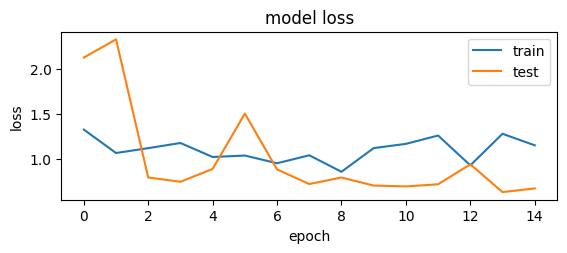

In [ ]:
# Plot model loss, train vs test
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')